In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ls.config.loader import load_config
import IPython.display as ipd
import torch

In [3]:
# --- 1. load config ---
cfg = load_config("../configs/config.yaml")

print(cfg.keys())

dict_keys(['seed', 'dataset', 'audio', 'models', 'training', 'mlflow'])


### ICBHI Dataloader using only test set as the validation set

In [4]:
# # Regular training
from ls.data.dataloaders import build_dataloaders


train_loader, test_loader = build_dataloaders(cfg.dataset, cfg.audio)

[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)
[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[ICBHI] Extracted 4142 respiratory cycles from 539 recordings
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 4142 cycles (base cycles only, aug handled dynamically)
  Class 0: 2063 (49.8%)
  Class 1: 1215 (29.3%)
  Class 2: 501 (12.1%)
  Class 3: 363 (8.8%)
[ICBHI] Active waveform augmentations: Loudness, VTLP
[ICBHI] Active spectrogram augmentations: SpecAugment
[ICBHI] Expected P(augmented) ≈ 0.43 (~1793/4142 per epoch)


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[ICBHI] Extracted 2756 respiratory cycles from 381 recordings
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 2756 cycles (base cycles only, aug handled dynamically)
  Class 0: 1579 (57.3%)
  Class 1: 649 (23.5%)
  Class 2: 385 (14.0%)
  Class 3: 143 (5.2%)
[ICBHI] No waveform augmentations
[ICBHI] No spectrogram augmentations


In [5]:
for batch in train_loader:
    print(batch["input_values"].shape, batch["label"].shape, batch["filename"])
    break

torch.Size([8, 1, 128, 1024]) torch.Size([8]) ['141_1b3_Pr_mc_LittC2SE', '203_1p3_Tc_mc_AKGC417L', '164_1b1_Ll_sc_Meditron', '193_1b2_Pl_mc_AKGC417L', '162_2b4_Lr_mc_AKGC417L', '158_2p3_Tc_mc_AKGC417L', '181_1b2_Ar_mc_LittC2SE', '186_3b3_Ar_mc_AKGC417L']


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Inspecting sample index 7 in the batch
Keys: dict_keys(['input_values', 'labels', 'audio', 'label', 'filename', 'cycle_index', 'duration', 'start_time', 'end_time', 'crackle', 'wheeze', 'fbank', 'aug_audio', 'aug_fbank'])
Filename: 186_3b3_Ar_mc_AKGC417L
Cycle index: tensor(4)
Label: tensor(1)
Duration: tensor(3.4050, dtype=torch.float64)
Start-End: tensor(15.3870, dtype=torch.float64) - tensor(18.7920, dtype=torch.float64)
Crackle/Wheeze: tensor(1) tensor(0)
Waveform shape: torch.Size([1, 160000])
Mel image shape: torch.Size([1, 128, 1024])


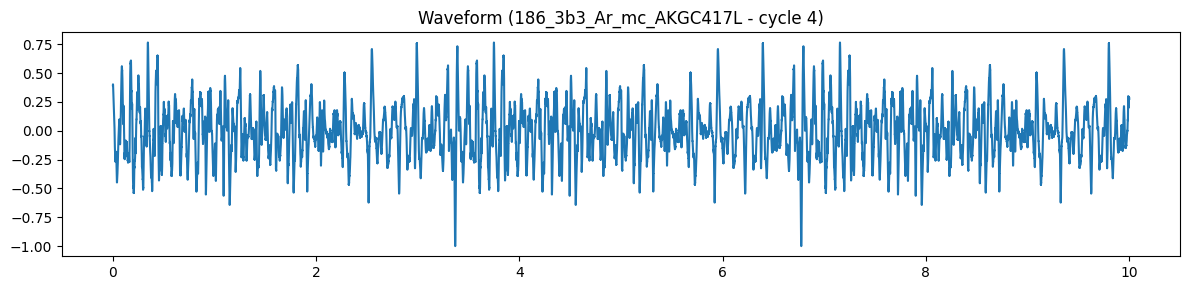

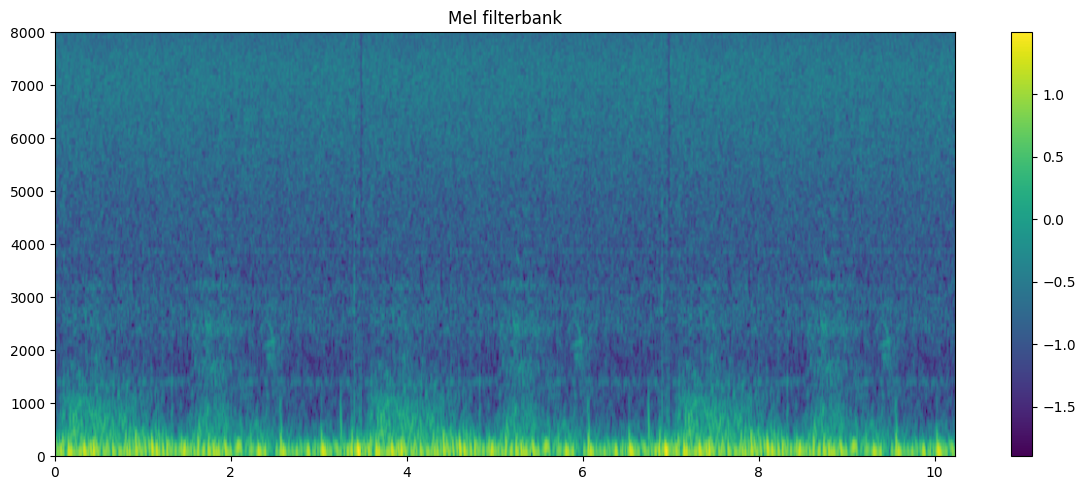

In [6]:
# --- Inspect one sample ---
idx = torch.randint(cfg.dataset.batch_size, (1,)).item()
print(f"Inspecting sample index {idx} in the batch")
print("Keys:", batch.keys())
print("Filename:", batch["filename"][idx])
print("Cycle index:", batch["cycle_index"][idx])
print("Label:", batch["label"][idx])
print("Duration:", batch["duration"][idx])
print("Start-End:", batch["start_time"][idx], "-", batch["end_time"][idx])
print("Crackle/Wheeze:", batch["crackle"][idx], batch["wheeze"][idx])
# print(sample["aug_audio"].shape, sample["aug_fbank"].shape, sample["audio"].shape, sample["fbank"].shape)
print("Waveform shape:", batch["audio"][idx].shape)
print("Mel image shape:", batch["input_values"][idx].shape)
# print(f"Waveform augmented: {not tensors_equal(batch['audio'][idx].view(-1), batch['aug_audio'][idx].view(-1))}")
# print(f"Mel augmented: {not tensors_equal(batch['fbank'][idx].view(-1), batch['aug_fbank'][idx].view(-1))}")

# --- 4. Plot waveform ---
waveform = batch["audio"][idx].squeeze().numpy()
plt.figure(figsize=(12, 3))
plt.plot(np.arange(waveform.shape[0]) / cfg.audio.sample_rate, waveform)
plt.title(f"Waveform ({batch['filename'][idx]} - cycle {batch['cycle_index'][idx]})")
plt.tight_layout()
plt.show()

# --- 5. Plot mel spectrogram ---
mel = batch["input_values"][idx].squeeze(0) # [freq, time] for imshow
freq_axis = np.linspace(0, cfg.audio.sample_rate // 2, mel.shape[0])
time_axis = np.arange(mel.shape[1]) * cfg.audio.frame_shift / 1000  # in seconds
plt.figure(figsize=(12, 5))
plt.imshow(mel, origin="lower", aspect="auto", extent=[0, time_axis[-1], 0, freq_axis[-1]], cmap="viridis")
plt.title("Mel filterbank")
plt.colorbar()
plt.tight_layout()
plt.show()

ipd.Audio(waveform, rate=cfg.audio.sample_rate)  # listen to the sound

In [7]:
from ls.models.ast import ASTModel

[Device] Using Apple Metal (MPS) acceleration


In [8]:
from ls.config.dataclasses.models import ASTConfig

ast_cfg = ASTConfig(**cfg.models.ast)
ast_cfg

ASTConfig(audioset_pretrain=True, input_fdim=128, input_tdim=1024, model_size='base384', fstride=10, tstride=10, imagenet_pretrain=True, label_dim=4, backbone_only=False, audioset_ckpt_path='/Users/gkont/Documents/Code/pretrained_models/audioset_10_10_0.4593.pth')

In [9]:
ast_mdl = ASTModel(
    **cfg.models.ast
)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
Loading AudioSet pretrained model from /Users/gkont/Documents/Code/pretrained_models/audioset_10_10_0.4593.pth
Vision transformer model size base384 created.
frequncey stride=10, time stride=10
number of patches=1212


In [10]:
print(ast_mdl)

ASTModel(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): Layer

In [11]:
print(batch["input_values"].shape) # (B, 1, freq, time)

torch.Size([8, 1, 128, 1024])


In [12]:
logits = ast_mdl(batch["input_values"])
print("Logits shape:", logits.shape)  # [B, num_classes]

Logits shape: torch.Size([8, 4])


## Or Using Hugging Face's

In [ ]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from datasets import load_dataset
import torch

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

print(model)
print(feature_extractor)